# Preparazione dei Dati

#### Upload in bucket_raw

Mi creo la funzione per caricare i file dalla mia macchina  al bucket_row su S3:

In [ ]:
import boto3
import logging
from botocore.exceptions import ClientError
import pandas as pd
import os
import statistics

In [10]:
s3_client = boto3.client("s3",region_name="eu-north-1")
def upload_files(file_name,bucket_name):
    try:
        response = s3_client.upload_file(file_name, bucket_name,os.path.basename(file_name))
        return response
    except ClientError as e:
        logging.error(e)
        return None


In [4]:
#leggo il contenuto della cartella dove sono i csv
files = os.listdir(r"C:\Users\aless\OneDrive\Desktop\PROFESSION AI\AWS_Cloud\datasets")

In [11]:
for file in files:
    upload_files(file,"bucket--raw")

#### Columns checking in Glue ETL notebook

Carico i file da S3 in Glue ETL notebook per fare un semplice controllo della coerenza e del tipo delle colonne :

In [ ]:
#carico i file da S3
BTC_EUR_Historical_Data = pd.read_csv("s3://bucket--raw/BTC_EUR_Historical_Data.csv",delimiter=',', decimal='.', thousands=',')
XMR_EUR_Kraken_Historical_Data = pd.read_csv("s3://bucket--raw/XMR_EUR Kraken Historical Data.csv",delimiter=',', decimal='.', thousands=',')
google_trend_bitcoin = pd.read_csv("s3://bucket--raw/google_trend_bitcoin.csv")
google_trend_monero = pd.read_csv("s3://bucket--raw/google_trend_monero.csv")

In [ ]:
#controllo se ci sono valori minori di zero negli indici di googl_trend
print(google_trend_bitcoin[google_trend_bitcoin['interesse bitcoin']<0])
print(google_trend_monero[google_trend_monero['Monero_interesse']<0])


Empty DataFrame
Columns: [Settimana, interesse bitcoin]
Index: []
Empty DataFrame
Columns: [Settimana, Monero_interesse]
Index: []


In [ ]:
#controllo se ci sono date o settimane duplicate
print(f'Date in BTC_EUR_Historical_Data duplicate: {BTC_EUR_Historical_Data.Date.duplicated().sum()}')
print(f'Date in XMR_EUR_Kraken_Historical_Data duplicate: {XMR_EUR_Kraken_Historical_Data.Date.duplicated().sum()}')
print(f'Settimane in google_trend_bitcoin duplicate: {google_trend_bitcoin.Settimana.duplicated().sum()}')
print(f'Settimane in google_trend_monero duplicate: {google_trend_monero.Settimana.duplicated().sum()}')

Date in BTC_EUR_Historical_Data duplicate: 0
Date in XMR_EUR_Kraken_Historical_Data duplicate: 0
Settimane in google_trend_bitcoin duplicate: 0
Settimane in google_trend_monero duplicate: 0


In [ ]:
BTC_EUR_Historical_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1887 non-null   object 
 1   Price     1887 non-null   float64
 2   Open      1887 non-null   float64
 3   High      1887 non-null   float64
 4   Low       1887 non-null   float64
 5   Vol.      1887 non-null   object 
 6   Change %  1887 non-null   object 
dtypes: float64(4), object(3)
memory usage: 103.3+ KB


In [ ]:
XMR_EUR_Kraken_Historical_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1898 entries, 0 to 1897
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1898 non-null   object 
 1   Price     1898 non-null   float64
 2   Open      1898 non-null   float64
 3   High      1898 non-null   float64
 4   Low       1898 non-null   float64
 5   Vol.      1895 non-null   object 
 6   Change %  1898 non-null   object 
dtypes: float64(4), object(3)
memory usage: 103.9+ KB


In [ ]:
google_trend_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Settimana          260 non-null    object
 1   interesse bitcoin  260 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [ ]:
google_trend_monero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Settimana         260 non-null    object
 1   Monero_interesse  260 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


#### Upload in bucket_argento

Ho utilizzato il servizio di Glue ETL per svolgere le trasformazioni sui dati, ho creato 2 script distinti per Monero e Bitcoin.                                                
Di seguito ho riportato il codice che ho utilizzato su Glue ETL :

 BTC_EUR

In [ ]:
import pandas as pd
import statistics
#Scarico i file di Bitcoin da S3 bucket--raw:
BTC_EUR_Historical_Data = pd.read_csv("s3://bucket--raw/BTC_EUR_Historical_Data.csv",delimiter=',', decimal='.', thousands=',')
google_trend_bitcoin = pd.read_csv("s3://bucket--raw/google_trend_bitcoin.csv")

#Faccio lo slicing delle prime 2 colonne e modifico il tipo di 'Date' in datetime.
#la colonna 'Price' è già tipo float, arrotondo semplicemente il dato a 2 cifre dopo la virgola :
BTC_EUR_Historical_Data = BTC_EUR_Historical_Data.iloc[:,0:2]
BTC_EUR_Historical_Data.Price = BTC_EUR_Historical_Data.Price.round(2)
BTC_EUR_Historical_Data.Date = pd.to_datetime(BTC_EUR_Historical_Data.Date, format='%m/%d/%Y')
BTC_EUR_Historical_Data = BTC_EUR_Historical_Data.sort_values(by = 'Date',  ignore_index=True)

#Modifico il nome colonna da 'Settimana' a 'Date' e la converto in tipo datetime.
#Modifico il nome della colonna 'interesse bitcoin' in 'index_bitcoin'
google_trend_bitcoin = google_trend_bitcoin.rename(columns={'Settimana': 'Date'})
google_trend_bitcoin = google_trend_bitcoin.rename(columns={'interesse bitcoin': 'index_bitcoin'})
google_trend_bitcoin.Date = pd.to_datetime(google_trend_bitcoin.Date)
google_trend_bitcoin = google_trend_bitcoin.sort_values(by = 'Date',  ignore_index=True)

#Sostituisco i valori -1 nella colonna 'Price' con la mediana dei 5 giorni precedenti.
for i in BTC_EUR_Historical_Data.index:
    if BTC_EUR_Historical_Data.Price.loc[i]<0:
        median_price = BTC_EUR_Historical_Data.Price.iloc[i-5:i].median()
        BTC_EUR_Historical_Data.Price.loc[i] = median_price

#Salvo i datasets nel bucket--argento:
BTC_EUR_Historical_Data.to_parquet("s3://bucket--argento/BTC_EUR_Historical_Data.parquet", index = False)
google_trend_bitcoin.to_parquet("s3://bucket--argento/google_trend_bitcoin.parquet",index = False)


XMR_EUR

In [ ]:
import pandas as pd
import statistics
#Scarico i file di Monero da S3 bucket--raw:
XMR_EUR_Kraken_Historical_Data = pd.read_csv("s3://bucket--raw/XMR_EUR Kraken Historical Data.csv",delimiter=',', decimal='.', thousands=',')
google_trend_monero = pd.read_csv("s3://bucket--raw/google_trend_monero.csv")

##Faccio lo slicing delle prime 2 colonne e modifico il tipo di 'Date' in datetime.
#la colonna 'Price' è già tipo float, arrotondo semplicemente il dato a 2 cifre dopo la virgola :
XMR_EUR_Kraken_Historical_Data = XMR_EUR_Kraken_Historical_Data.iloc[:,0:2]
XMR_EUR_Kraken_Historical_Data.Price = XMR_EUR_Kraken_Historical_Data.Price.round(2)
XMR_EUR_Kraken_Historical_Data.Date = pd.to_datetime(XMR_EUR_Kraken_Historical_Data.Date, format='%m/%d/%Y')
XMR_EUR_Kraken_Historical_Data = XMR_EUR_Kraken_Historical_Data.sort_values(by = 'Date',  ignore_index=True)

#Modifico il nome colonna da 'Settimana' a 'Date' e la converto in tipo datetime.
#Modifico il nome della colonna 'Monero_interesse' in 'index_monero':
google_trend_monero = google_trend_monero.rename(columns={'Settimana': 'Date'})
google_trend_monero = google_trend_monero.rename(columns={'Monero_interesse': 'index_monero'})
google_trend_monero.Date = pd.to_datetime(google_trend_monero.Date)
google_trend_monero = google_trend_monero.sort_values(by = 'Date',  ignore_index=True)

#Sostituisco i valori -1 nella colonna Price con la mediana dei 5 giorni precedenti:
for i in XMR_EUR_Kraken_Historical_Data.index:
    if XMR_EUR_Kraken_Historical_Data.Price.loc[i]<0:
        median_price = XMR_EUR_Kraken_Historical_Data.Price.iloc[i-5:i].median()
        XMR_EUR_Kraken_Historical_Data.Price.loc[i] = median_price

#Salvo i datasets nel bucket--argento:
XMR_EUR_Kraken_Historical_Data.to_parquet("s3://bucket--argento/XMR_EUR Kraken Historical Data.parquet", index = False)
google_trend_monero.to_parquet("s3://bucket--argento/google_trend_monero.parquet", index = False)

# Analisi e Unificazione dei Dati

### Upload in bucket_oro

Ho utilizzato il servizio di Glue ETL per svolgere le trasformazioni sui dati, ho creato 2 script distinti per Monero e Bitcoin.                                               Per smussare il prezzo ho usato la mediana mobile su 10 giorni, perchè i prezzi delle valute sono molto volatilie soggetti a picchi improvvisi.                                             
Di seguito ho riportato il codice che ho utilizzato su Glue ETL :

 BTC_EUR

In [ ]:
import pandas as pd
#Scarico i file di Bitcoin da S3 bucket--argento:
BTC_EUR_Historical_Data = pd.read_parquet("s3://bucket--argento/BTC_EUR_Historical_Data.parquet")
google_trend_bitcoin = pd.read_parquet("s3://bucket--argento/google_trend_bitcoin.parquet")

#Applico la mediana mobile sulla colonna 'Price' del dataset BTC per smussare il prezzo e poter joinare con google_trend_bitcoin:
BTC_EUR_Historical_Data['Price'] = BTC_EUR_Historical_Data['Price'].rolling(window=10).median().round(2)
    
#Faccio il merge tra i 2 dataset con colonna chiave 'Date' e salvo il contenuto nel bucket--oro:
BTC_EUR_merged = pd.merge(BTC_EUR_Historical_Data, google_trend_bitcoin, on='Date', how='inner')
BTC_EUR_merged.to_parquet("s3://bucket--oro/BTC_EUR_Historical_Data.parquet", index = False)


XMR_EUR

In [ ]:
import pandas as pd
#Scarico i file di Monero da S3 bucket--argento:
XMR_EUR_Kraken_Historical_Data = pd.read_parquet("s3://bucket--argento/XMR_EUR Kraken Historical Data.parquet")
google_trend_monero = pd.read_parquet("s3://bucket--argento/google_trend_monero.parquet")

#Applico la media mobile sulla colonna 'Price' del dataset XMR per smussare il prezzo e poter joinare con google_trend_monero:
XMR_EUR_Kraken_Historical_Data['Price'] = XMR_EUR_Kraken_Historical_Data['Price'].rolling(window=10).median()
    
#Faccio il merge tra i 2 dataset con colonna chiave 'Date' e salvo il contenuto nel bucket--oro:
XMR_EUR_merged = pd.merge(XMR_EUR_Kraken_Historical_Data, google_trend_monero, on='Date', how='inner')
XMR_EUR_merged.to_parquet("s3://bucket--oro/XMR_EUR Kraken Historical Data.parquet", index = False)

# Caricamento su Redshift e Visualizzazione

### Redshift

Per caricare le tabelle con i dati da S3 a Redshift ho deciso di utilizzare Glue ETL con Python. Per consentire il trasferimento dei dati ho creato un ruolo su IAM in modo tale da poter utilizzare tutti e 3 i servizi. Ho deciso di caricare le tabelle con il 'DISTSTYLE KEY' così che in futuro si possano effettuare dei join tra le tabelle monero e bitcoin per un confronto.

 BTC_EUR

In [ ]:
import redshift_connector
conn_info = {
    "host" : "prova-finale.905418128774.eu-north-1.redshift-serverless.amazonaws.com",
    "database" : "professionai",
    "user" : "admin",
    "password" : "my_password",
    "port" : 5439,
}
#creo una query per creare la tabella per BTC_EUR :
BTC_EUR_table = """CREATE TABLE my_schema.bitcoin_index (
    Data DATE,
    Price FLOAT,
    index BIGINT
)
DISTSTYLE KEY
DISTKEY (Data)
SORTKEY (Data);
"""
#inserisco i dati di s3 dentro la tabella :
BTC_EUR_data = """
COPY my_schema.Bitcoin_index
FROM 's3://bucket--oro/BTC_EUR_Historical_Data.parquet'
IAM_ROLE 'arn:aws:iam::905418128774:role/my_Redshift_role_S3'
FORMAT AS PARQUET;
"""
with redshift_connector.connect(**conn_info) as conn:
    with conn.cursor() as cursor:
        # Rollback per assicurarci che non ci siano transazioni in sospeso
        conn.rollback()
        # Abilita l'autocommit per assicurarsi che le operazioni vengano confermate automaticamente
        conn.autocommit = True
        #create table  my_schema.Bitcoin_index
        cursor.execute(BTC_EUR_table)
        #insert data into table
        cursor.execute(BTC_EUR_data)
        # Esegui VACUUM per ottimizzare la tabella(eseguire con cadenza settimanale non in load)
        cursor.execute("VACUUM my_schema.bitcoin_index")
        # Disabilita l'autocommit per tornare alla modalità transazionale normale
        conn.autocommit = False

XMR_EUR

In [ ]:
import redshift_connector
conn_info = {
    "host" : "prova-finale.905418128774.eu-north-1.redshift-serverless.amazonaws.com",
    "database" : "professionai",
    "user" : "admin",
    "password" : "my_password",
    "port" : 5439,
}
#creo una query per creare la tabella per BTC_EUR :
XMR_EUR_table = """CREATE TABLE my_schema.monero_index (
    Data DATE,
    Price FLOAT,
    index BIGINT
)
DISTSTYLE KEY
DISTKEY (Data)
SORTKEY (Data);

"""
#inserisco i dati di s3 dentro la tabella :
XMR_EUR_data = """
COPY my_schema.monero_index
FROM 's3://bucket--oro/XMR_EUR Kraken Historical Data.parquet'
IAM_ROLE 'arn:aws:iam::905418128774:role/my_Redshift_role_S3'
FORMAT AS PARQUET;
"""
with redshift_connector.connect(**conn_info) as conn:
    with conn.cursor() as cursor:
        # Rollback per assicurarci che non ci siano transazioni in sospeso
        conn.rollback()
        # Abilita l'autocommit per assicurarsi che le operazioni vengano confermate automaticamente
        conn.autocommit = True
        #creo la tabella
        cursor.execute(XMR_EUR_table)
        #inserisco i dati
        cursor.execute(XMR_EUR_data)
        # Esegui VACUUM per ottimizzare la tabella(eseguire con cadenza settimanale non in load)
        conn.run("VACUUM")
        # Disabilita l'autocommit per tornare alla modalità transazionale normale
        conn.autocommit = False

### Step Functions

Per automizzare il processo ho creato una macchina su Step Functions, nella quale ho creato 2 pipeline in parallelo che eseguono gli script Glue ETL in contemporanea. Ho deciso di impostare il retry degli errori solamente nel caso in cui ci sia un Timeout, in quanto negli altri casi potrebbe essere dovuto ad un errore nel codice.

In [19]:
from PIL import Image
image_path_1 = r"C:\Users\aless\OneDrive\Desktop\PROFESSION AI\AWS_Cloud\step_functions.png"
image_path_2 = r"C:\Users\aless\OneDrive\Desktop\PROFESSION AI\AWS_Cloud\step_functions_succeded.png"
img = Image.open(image_path_1)
img_2 = Image.open(image_path_2)

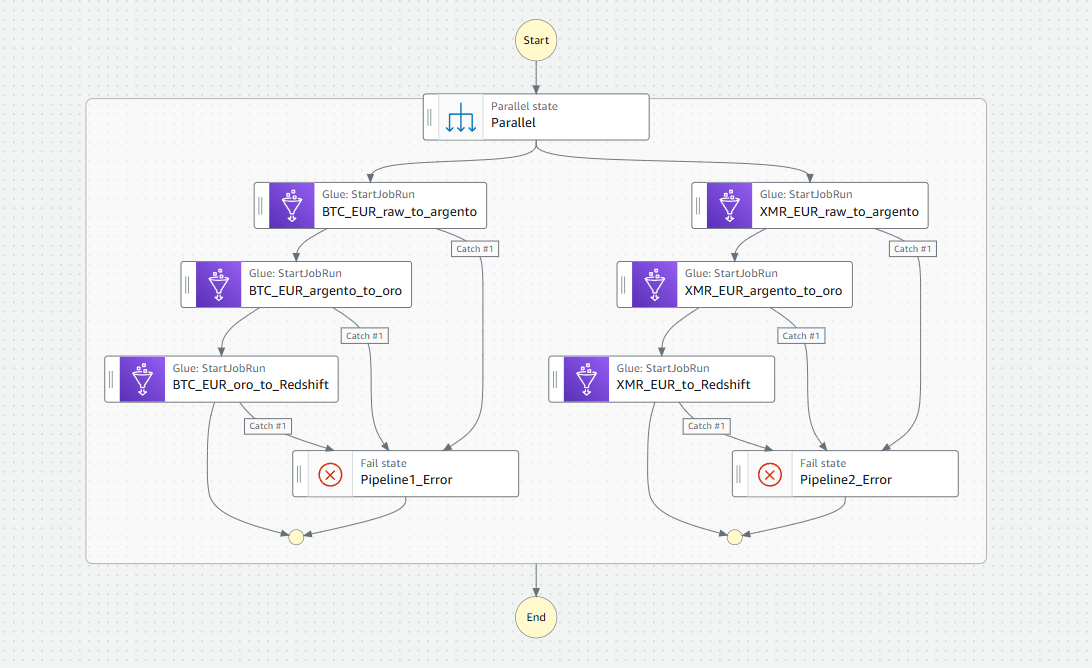

In [17]:
img

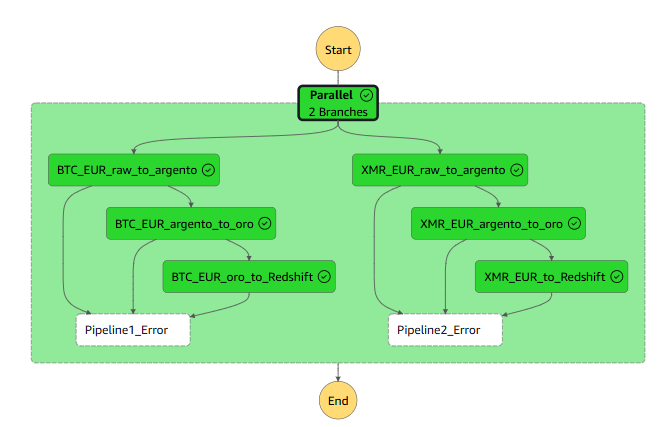

In [20]:
img_2

Codice:

In [ ]:
{
  "Comment": "Esempio di Step Function con due pipeline in parallelo e gestione degli errori",
  "StartAt": "Parallel",
  "States": {
    "Parallel": {
      "Type": "Parallel",
      "Branches": [
        {
          "StartAt": "BTC_EUR_raw_to_argento",
          "States": {
            "BTC_EUR_raw_to_argento": {
              "Type": "Task",
              "Resource": "arn:aws:states:::glue:startJobRun.sync",
              "Parameters": {
                "JobName": "BTC_EUR"
              },
              "Next": "BTC_EUR_argento_to_oro",
              "Catch": [
                {
                  "ErrorEquals": [
                    "States.ALL"
                  ],
                  "Next": "Pipeline1_Error"
                }
              ],
              "Retry": [
                {
                  "ErrorEquals": [
                    "States.Timeout",
                    "States.HeartbeatTimeout"
                  ],
                  "BackoffRate": 2,
                  "IntervalSeconds": 1,
                  "MaxAttempts": 3
                }
              ]
            },
            "BTC_EUR_argento_to_oro": {
              "Type": "Task",
              "Resource": "arn:aws:states:::glue:startJobRun.sync",
              "Parameters": {
                "JobName": "BTC_EUR_oro"
              },
              "Next": "BTC_EUR_oro_to_Redshift",
              "Catch": [
                {
                  "ErrorEquals": [
                    "States.ALL"
                  ],
                  "Next": "Pipeline1_Error"
                }
              ],
              "Retry": [
                {
                  "ErrorEquals": [
                    "States.Timeout",
                    "States.HeartbeatTimeout"
                  ],
                  "BackoffRate": 2,
                  "IntervalSeconds": 1,
                  "MaxAttempts": 3
                }
              ]
            },
            "BTC_EUR_oro_to_Redshift": {
              "Type": "Task",
              "Resource": "arn:aws:states:::glue:startJobRun.sync",
              "Parameters": {
                "JobName": "BTC_EUR_S3_to_Redshift"
              },
              "Catch": [
                {
                  "ErrorEquals": [
                    "States.ALL"
                  ],
                  "Next": "Pipeline1_Error"
                }
              ],
              "Retry": [
                {
                  "ErrorEquals": [
                    "States.Timeout",
                    "States.HeartbeatTimeout"
                  ],
                  "IntervalSeconds": 1,
                  "MaxAttempts": 3,
                  "BackoffRate": 1
                }
              ],
              "End": true
            },
            "Pipeline1_Error": {
              "Type": "Fail",
              "Cause": "Pipeline1 encountered an error"
            }
          }
        },
        {
          "StartAt": "XMR_EUR_raw_to_argento",
          "States": {
            "XMR_EUR_raw_to_argento": {
              "Type": "Task",
              "Resource": "arn:aws:states:::glue:startJobRun.sync",
              "Parameters": {
                "JobName": "XMR_EUR"
              },
              "Next": "XMR_EUR_argento_to_oro",
              "Catch": [
                {
                  "ErrorEquals": [
                    "States.ALL"
                  ],
                  "Next": "Pipeline2_Error"
                }
              ],
              "Retry": [
                {
                  "ErrorEquals": [
                    "States.Timeout",
                    "States.HeartbeatTimeout"
                  ],
                  "BackoffRate": 2,
                  "IntervalSeconds": 1,
                  "MaxAttempts": 3
                }
              ]
            },
            "XMR_EUR_argento_to_oro": {
              "Type": "Task",
              "Resource": "arn:aws:states:::glue:startJobRun.sync",
              "Parameters": {
                "JobName": "XMR_EUR_oro"
              },
              "Next": "XMR_EUR_to_Redshift",
              "Catch": [
                {
                  "ErrorEquals": [
                    "States.ALL"
                  ],
                  "Next": "Pipeline2_Error"
                }
              ],
              "Retry": [
                {
                  "ErrorEquals": [
                    "States.Timeout",
                    "States.HeartbeatTimeout"
                  ],
                  "BackoffRate": 2,
                  "IntervalSeconds": 1,
                  "MaxAttempts": 3
                }
              ]
            },
            "XMR_EUR_to_Redshift": {
              "Type": "Task",
              "Resource": "arn:aws:states:::glue:startJobRun.sync",
              "Parameters": {
                "JobName": "XMR_EUR_S3_to_Redshift"
              },
              "Catch": [
                {
                  "ErrorEquals": [
                    "States.ALL"
                  ],
                  "Next": "Pipeline2_Error"
                }
              ],
              "Retry": [
                {
                  "ErrorEquals": [
                    "States.Timeout",
                    "States.HeartbeatTimeout"
                  ],
                  "BackoffRate": 2,
                  "IntervalSeconds": 1,
                  "MaxAttempts": 3
                }
              ],
              "End": true
            },
            "Pipeline2_Error": {
              "Type": "Fail",
              "Cause": "Pipeline2 encountered an error"
            }
          }
        }
      ],
      "End": true
    }
  }
}

### QuickSight

Attraverso i grafici si può individuare come l'andamento del prezzo delle due valute è molto influenzato dall'andamento dell'indice.

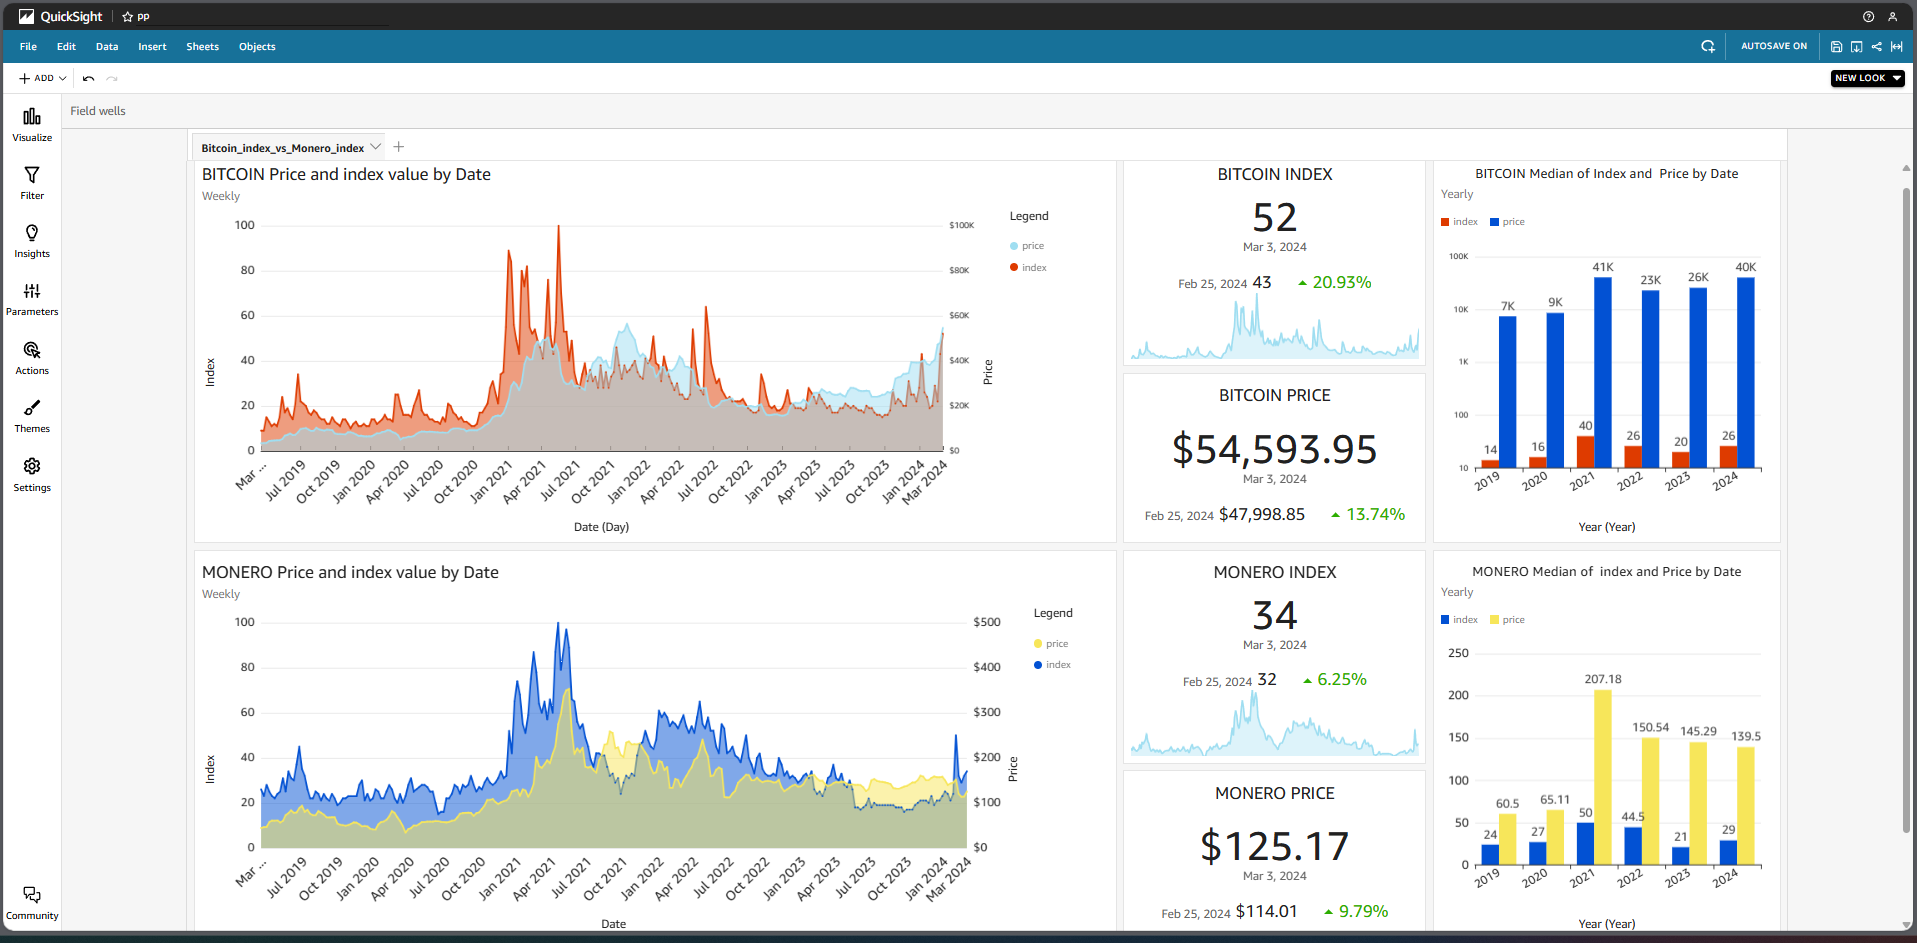

In [27]:
image_path_3 = r"C:\Users\aless\OneDrive\Desktop\PROFESSION AI\AWS_Cloud\Alessandro_Spano_AWS\QuickSight.png"
img = Image.open(image_path_3)
img